In [4]:
# --- Imports ---
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

# --- Chargement des fichiers CSV ---
csv_paths = [
    r'C:/Users/moussb/Downloads/archive/amsterdam_weekdays.csv',
    r'C:/Users/moussb/Downloads/archive/amsterdam_weekends.csv',
    r'C:/Users/moussb/Downloads/archive/athens_weekdays.csv',
    r'C:/Users/moussb/Downloads/archive/athens_weekends.csv',
    r'C:/Users/moussb/Downloads/archive/barcelona_weekdays.csv',
    r'C:/Users/moussb/Downloads/archive/barcelona_weekends.csv',
    r'C:/Users/moussb/Downloads/archive/berlin_weekdays.csv',
    r'C:/Users/moussb/Downloads/archive/berlin_weekends.csv',
    r'C:/Users/moussb/Downloads/archive/budapest_weekdays.csv',
    r'C:/Users/moussb/Downloads/archive/budapest_weekends.csv',
    r'C:/Users/moussb/Downloads/archive/lisbon_weekdays.csv',
    r'C:/Users/moussb/Downloads/archive/lisbon_weekends.csv',
    r'C:/Users/moussb/Downloads/archive/london_weekdays.csv',
    r'C:/Users/moussb/Downloads/archive/london_weekends.csv',
    r'C:/Users/moussb/Downloads/archive/paris_weekdays.csv',
    r'C:/Users/moussb/Downloads/archive/paris_weekends.csv',
    r'C:/Users/moussb/Downloads/archive/rome_weekdays.csv',
    r'C:/Users/moussb/Downloads/archive/rome_weekends.csv',
    r'C:/Users/moussb/Downloads/archive/vienna_weekdays.csv',
    r'C:/Users/moussb/Downloads/archive/vienna_weekends.csv',
]

# Lire les fichiers CSV et combiner les données
dfs = []
cities_processed = set()

for path in csv_paths:
    try:
        if os.path.exists(path):
            df = pd.read_csv(path)
            city = os.path.basename(path).split('_')[0].capitalize()
            df['city'] = city
            df['is_weekend'] = "weekends" in path
            dfs.append(df)
            cities_processed.add(city)
        else:
            print(f"Le fichier {path} n'existe pas.")
    except Exception as e:
        print(f"Erreur lors de la lecture du fichier {path}: {e}")

# Concatenation des DataFrames
if dfs:
    original_data = pd.concat(dfs, ignore_index=True)
    print(f"Données combinées avec succès. {len(cities_processed)} villes traitées.")
else:
    print("Aucun fichier CSV n'a été chargé.")

# --- Aperçu des données ---
print("\nAperçu des données :")
print(original_data.head())

print("\nNombre d'entrées par ville :")
print(original_data['city'].value_counts())

print("\nNombre d'entrées par jour de la semaine :")
print(original_data['is_weekend'].value_counts())

print("\nColonnes du DataFrame :")
print(original_data.columns.tolist())

print("\nInformations sur le DataFrame :")
original_data.info()





Données combinées avec succès. 10 villes traitées.

Aperçu des données :
   Unnamed: 0     realSum     room_type  room_shared  room_private  \
0           0  194.033698  Private room        False          True   
1           1  344.245776  Private room        False          True   
2           2  264.101422  Private room        False          True   
3           3  433.529398  Private room        False          True   
4           4  485.552926  Private room        False          True   

   person_capacity  host_is_superhost  multi  biz  cleanliness_rating  ...  \
0              2.0              False      1    0                10.0  ...   
1              4.0              False      0    0                 8.0  ...   
2              2.0              False      0    1                 9.0  ...   
3              4.0              False      0    1                 9.0  ...   
4              2.0               True      0    0                10.0  ...   

       dist  metro_dist  attr_index  

### Distribution des données 
Le jeu de données couvre 9 villes européennes, avec Londres ayant le plus grand nombre d'entrées (9993) et Amsterdam le moins (2080).
Il y a une répartition presque égale entre les entrées de week-end (26207) et de jours de semaine (25500).

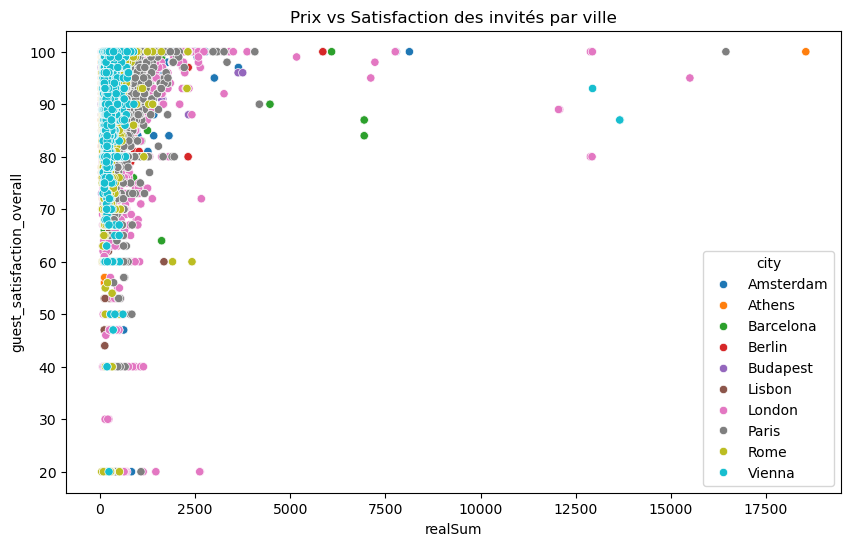

In [5]:
# --- Visualisations de base ---
# Relation entre le prix et la satisfaction des invités
plt.figure(figsize=(10, 6))
sns.scatterplot(data=original_data, x='realSum', y='guest_satisfaction_overall', hue='city')
plt.title('Prix vs Satisfaction des invités par ville')
plt.show()



## Relation prix vs satisfaction :

Il n'y a pas de corrélation linéaire forte entre le prix et la satisfaction globale des invités.

La majorité des locations se situent dans une fourchette de prix plus basse (moins de 5000), avec quelques valeurs aberrantes à des prix très élevés.

La satisfaction des clients est généralement élevée (au-dessus de 80) pour la plupart des locations, indépendamment du prix.

Chaque ville semble avoir sa propre distribution de prix et de satisfaction, suggérant des différences de marché entre les villes.

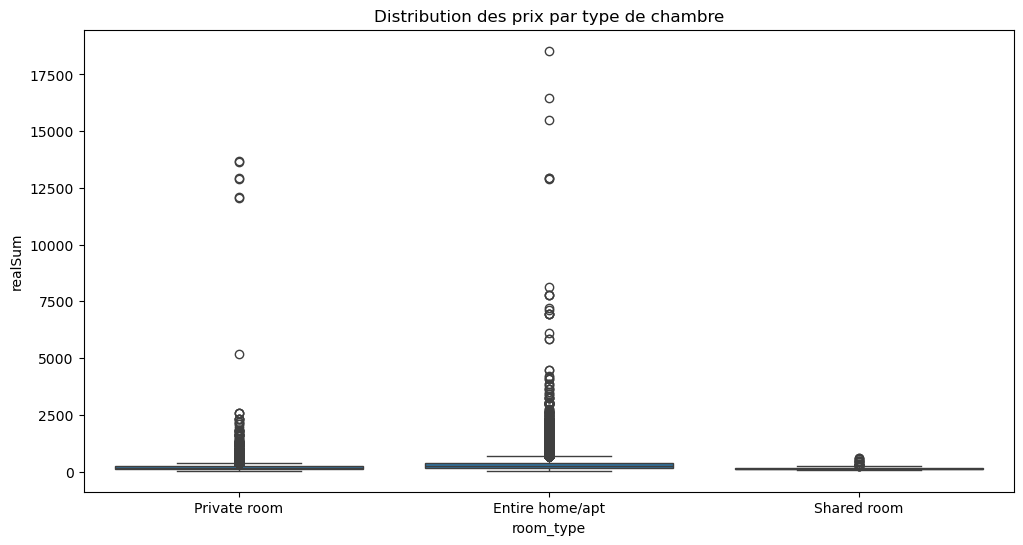

In [6]:
# Distribution des prix par type de chambre
plt.figure(figsize=(12, 6))
sns.boxplot(data=original_data, x='room_type', y='realSum')
plt.title('Distribution des prix par type de chambre')
plt.show()



## Distribution des prix par type de chambre  :

Les logements entiers ("Entire home/apt") ont généralement des prix plus élevés et une plus grande variabilité de prix que les chambres privées ou partagées.

Les chambres partagées ("Shared room") ont les prix les plus bas et la moindre variabilité.

Il y a de nombreuses valeurs aberrantes pour les logements entiers, suggérant l'existence de propriétés de luxe ou exceptionnelles.

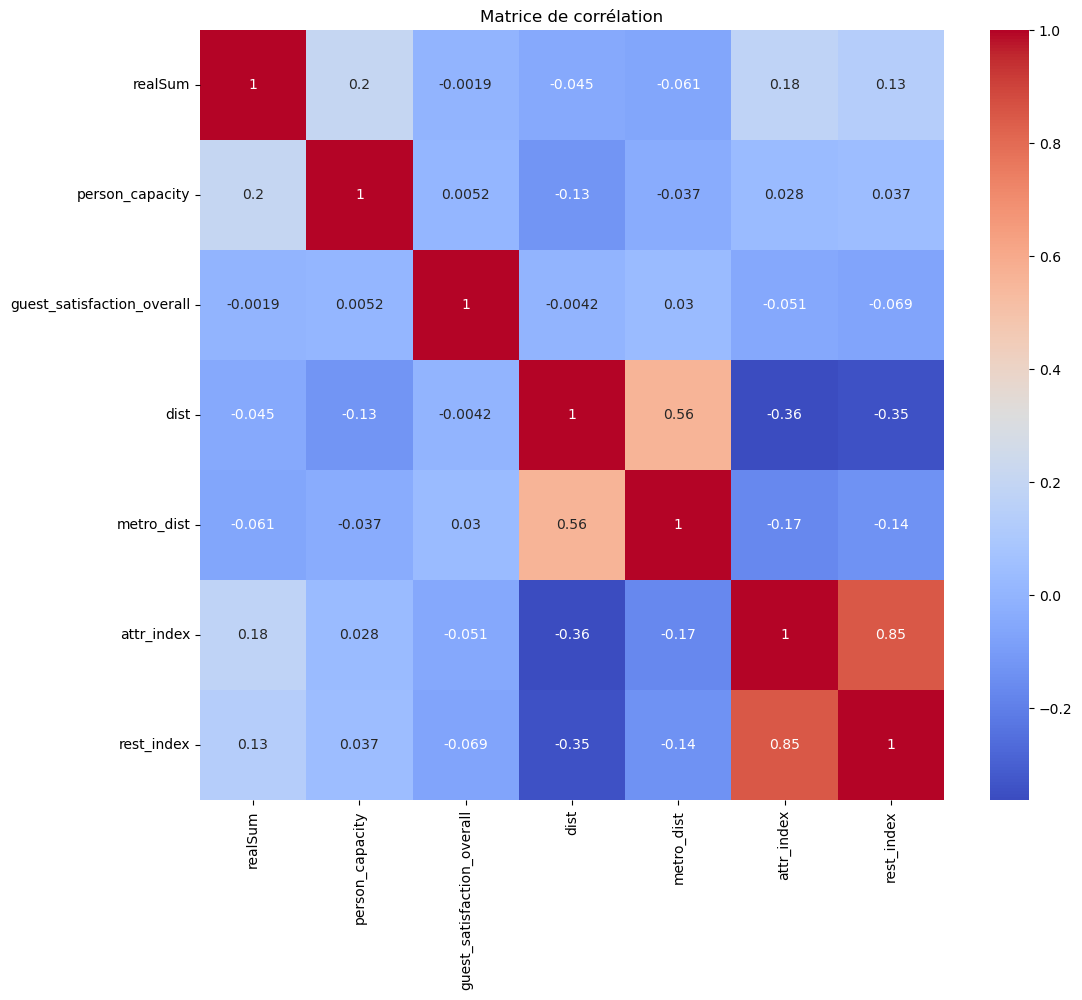

In [7]:
# Corrélation entre les variables numériques
correlation_matrix = original_data[['realSum', 'person_capacity', 'guest_satisfaction_overall', 'dist', 'metro_dist', 'attr_index', 'rest_index']].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.show()

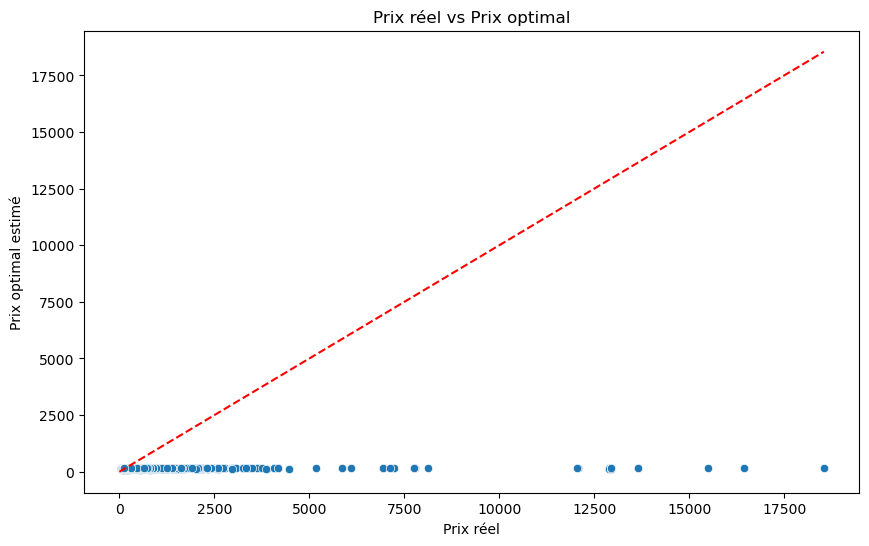

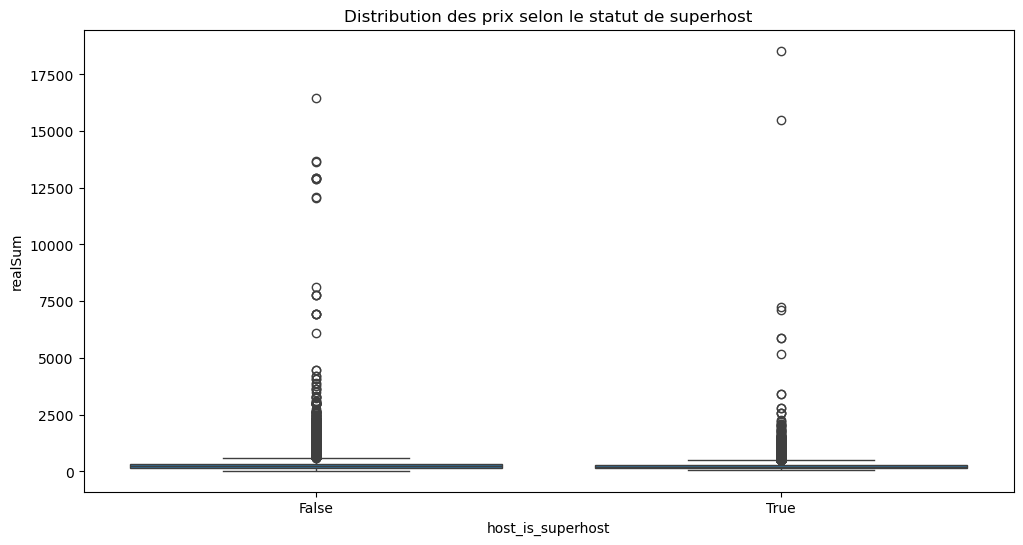

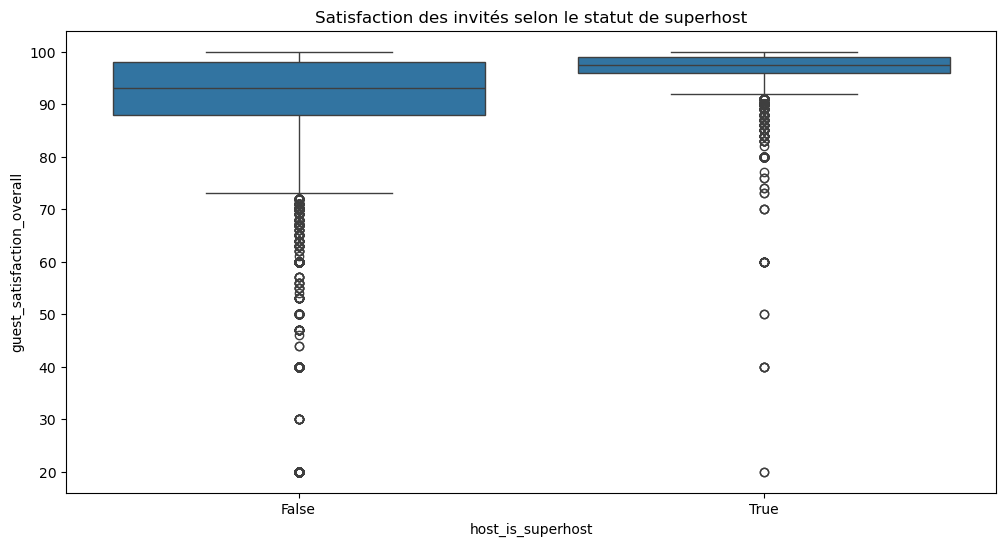

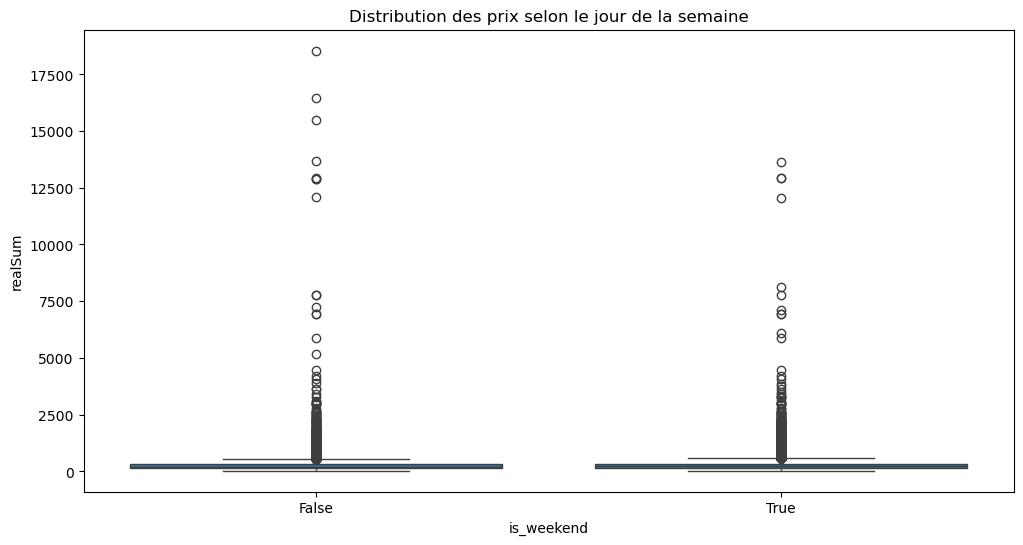

C:\Users\moussb\AppData\Local\Temp\ipykernel_13848\2529180844.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weekend_premium = original_data.groupby('city').apply(lambda x: x[x['is_weekend']]['realSum'].mean() - x[~x['is_weekend']]['realSum'].mean()).sort_values(ascending=False)


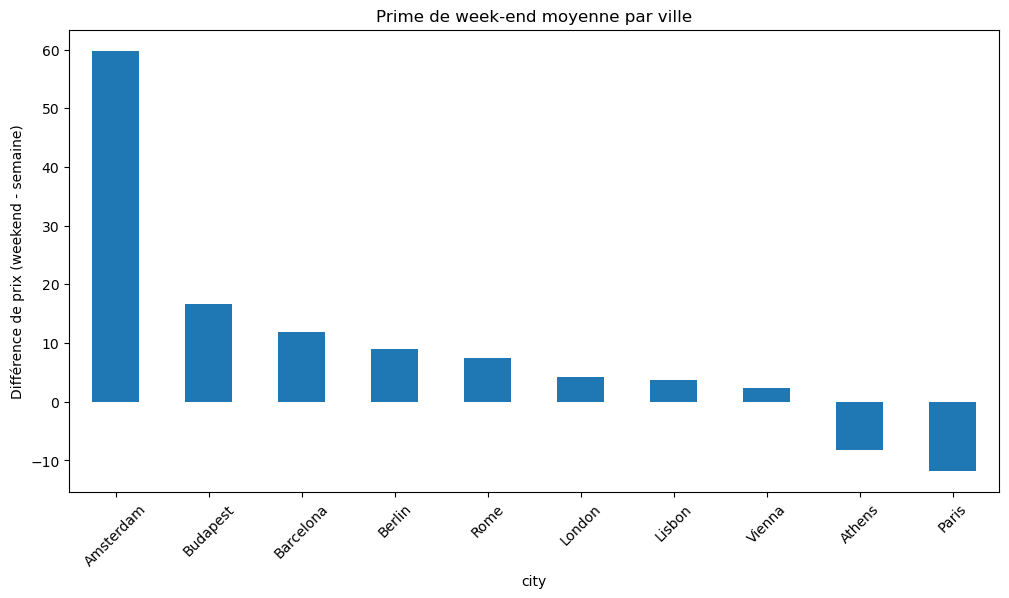

MSE: 104301.8926898441
R2 Score: 0.074995885252221
                      feature  importance
0             person_capacity   52.340738
1                        dist   12.150188
3                  attr_index    0.352573
5  guest_satisfaction_overall    0.291232
4                  rest_index   -0.037699
2                  metro_dist  -26.434660
Test de Mann-Whitney pour la satisfaction : statistique = 360821722.0, p-value = 0.0

Statistiques pour superhost:
count    13232.000000
mean        96.900242
std          3.441361
min         20.000000
25%         96.000000
50%         97.500000
75%         99.000000
max        100.000000
Name: guest_satisfaction_overall, dtype: float64
count    13232.000000
mean       254.447726
std        307.207550
min         45.227662
25%        143.748685
50%        197.040881
75%        282.635011
max      18545.450285
Name: realSum, dtype: float64

Statistiques pour non_superhost:
count    38475.000000
mean        91.159038
std          9.748642
min      

In [8]:
# --- Calcul des prix optimaux avec le modèle de Cournot ---
def calculate_optimal_price(competitors_prices, cost):
    return (np.mean(competitors_prices) + cost) / 2

# Grouper par quartier (en utilisant 'dist' comme proxy)
original_data['neighborhood'] = pd.cut(original_data['dist'], bins=10)

# Simuler un jeu de Cournot simplifié
for neighborhood in original_data['neighborhood'].unique():
    neighborhood_data = original_data[original_data['neighborhood'] == neighborhood]
    
    # Supposons un coût fixe par nuit
    fixed_cost = 20
    
    for index, row in neighborhood_data.iterrows():
        competitors = neighborhood_data[neighborhood_data.index != index]
        optimal_price = calculate_optimal_price(competitors['realSum'], fixed_cost)
        original_data.loc[index, 'optimal_price'] = optimal_price

# Comparer les prix réels aux prix optimaux
plt.figure(figsize=(10, 6))
sns.scatterplot(data=original_data, x='realSum', y='optimal_price')
plt.plot([0, original_data['realSum'].max()], [0, original_data['realSum'].max()], 'r--')
plt.title('Prix réel vs Prix optimal')
plt.xlabel('Prix réel')
plt.ylabel('Prix optimal estimé')
plt.show()

# --- Analyse des prix et de la satisfaction ---
plt.figure(figsize=(12, 6))
sns.boxplot(data=original_data, x='host_is_superhost', y='realSum')
plt.title('Distribution des prix selon le statut de superhost')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=original_data, x='host_is_superhost', y='guest_satisfaction_overall')
plt.title('Satisfaction des invités selon le statut de superhost')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=original_data, x='is_weekend', y='realSum')
plt.title('Distribution des prix selon le jour de la semaine')
plt.show()

# --- Calcul de la prime de week-end par ville ---
weekend_premium = original_data.groupby('city').apply(lambda x: x[x['is_weekend']]['realSum'].mean() - x[~x['is_weekend']]['realSum'].mean()).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
weekend_premium.plot(kind='bar')
plt.title('Prime de week-end moyenne par ville')
plt.ylabel('Différence de prix (weekend - semaine)')
plt.xticks(rotation=45)
plt.show()

# --- Modélisation de régression linéaire ---
features = ['person_capacity', 'dist', 'metro_dist', 'attr_index', 'rest_index', 'guest_satisfaction_overall']
X = original_data[features]
y = original_data['realSum']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('MSE:', mean_squared_error(y_test, y_pred))
print('R2 Score:', r2_score(y_test, y_pred))

# Importance des caractéristiques
feature_importance = pd.DataFrame({'feature': features, 'importance': model.coef_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print(feature_importance)

# --- Test de Mann-Whitney pour la satisfaction ---
superhost = original_data[original_data['host_is_superhost'] == True]
non_superhost = original_data[original_data['host_is_superhost'] == False]

statistic, p_value = stats.mannwhitneyu(superhost['guest_satisfaction_overall'], non_superhost['guest_satisfaction_overall'])

print(f"Test de Mann-Whitney pour la satisfaction : statistique = {statistic}, p-value = {p_value}")

# Statistiques descriptives par groupe
for group in ['superhost', 'non_superhost']:
    data = superhost if group == 'superhost' else non_superhost
    print(f"\nStatistiques pour {group}:")
    print(data['guest_satisfaction_overall'].describe())
    print(data['realSum'].describe())

# --- Analyse par ville ---
for city in original_data['city'].unique():
    city_data = original_data[original_data['city'] == city]
    superhost_city = city_data[city_data['host_is_superhost'] == True]
    non_superhost_city = city_data[city_data['host_is_superhost'] == False]
    
    print(f"\nAnalyse pour {city}:")
    print("Moyenne de satisfaction superhost:", superhost_city['guest_satisfaction_overall'].mean())
    print("Moyenne de satisfaction non-superhost:", non_superhost_city['guest_satisfaction_overall'].mean())
    print("Prix moyen superhost:", superhost_city['realSum'].mean())
    print("Prix moyen non-superhost:", non_superhost_city['realSum'].mean())

# --- Random Forest ---
features_rf = ['person_capacity', 'dist', 'metro_dist', 'attr_index', 'rest_index', 'guest_satisfaction_overall']
X_rf = original_data[features_rf]
y_rf = original_data['realSum']

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

y_pred_rf = rf_model.predict(X_test_rf)

print('Random Forest - MSE:', mean_squared_error(y_test_rf, y_pred_rf))
print('Random Forest - R2 Score:', r2_score(y_test_rf, y_pred_rf))


## Satisfaction selon le statut de superhost  :

Les superhosts ont tendance à avoir des notes de satisfaction globalement plus élevées que les hôtes normaux.

La médiane et le 75e percentile de satisfaction sont plus élevés pour les superhosts.

Il y a moins de valeurs aberrantes basses pour les superhosts, suggérant une plus grande cohérence dans la qualité du service.

## Prime de week-end moyenne par ville  :


Amsterdam se démarque nettement avec la plus forte prime de week-end, environ 60€ de plus en moyenne que les jours de semaine.Cela suggère une forte demande touristique le week-end à Amsterdam.

Budapest et Barcelone suivent avec des primes de week-end significatives, bien que moins élevées qu'Amsterdam (environ 17€ et 12€ respectivement).

La plupart des autres villes (Berlin, Rome, Londres, Lisbonne, Vienne) ont des primes de week-end positives mais plus modestes, allant de 2€ à 10€.

Fait intéressant, Athènes et Paris ont des primes de week-end négatives, ce qui signifie que les prix sont en moyenne légèrement plus bas le week-end que pendant la semaine. Cela pourrait s'expliquer par une plus forte demande de voyages d'affaires en semaine dans ces villes.

## Distribution des prix selon le jour de la semaine :


Globalement, la distribution des prix semble assez similaire entre les jours de semaine (False) et les week-ends (True).

Les deux périodes présentent une large gamme de prix, avec la majorité des logements se situant dans une fourchette de prix plus basse.

On observe des valeurs aberrantes (outliers) dans les deux cas, représentant des logements exceptionnellement chers, potentiellement des propriétés de luxe ou des locations spéciales.

Il semble y avoir une légère tendance à des prix plus élevés le week-end, comme en témoigne la position légèrement plus haute de la boîte pour les week-ends (True). Cela correspond aux primes de week-end positives observées dans la plupart des villes dans l'Image 1.

La variabilité des prix semble être légèrement plus grande le week-end, suggérant que certains propriétaires ajustent leurs prix de manière plus agressive pendant les périodes de forte demande.

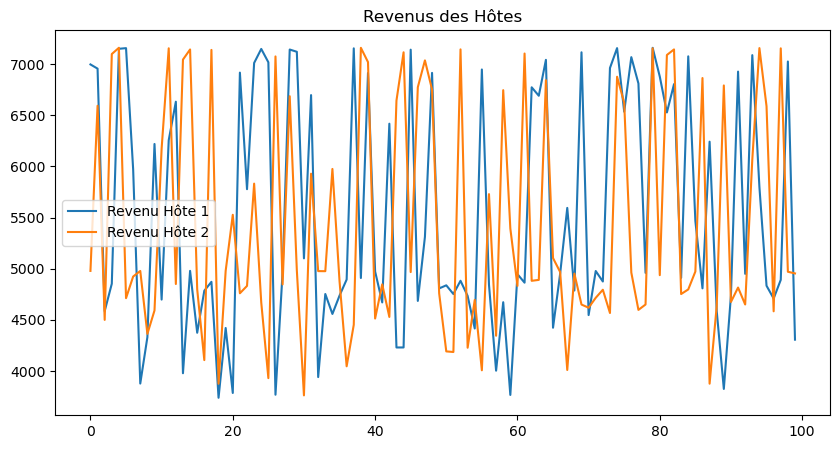

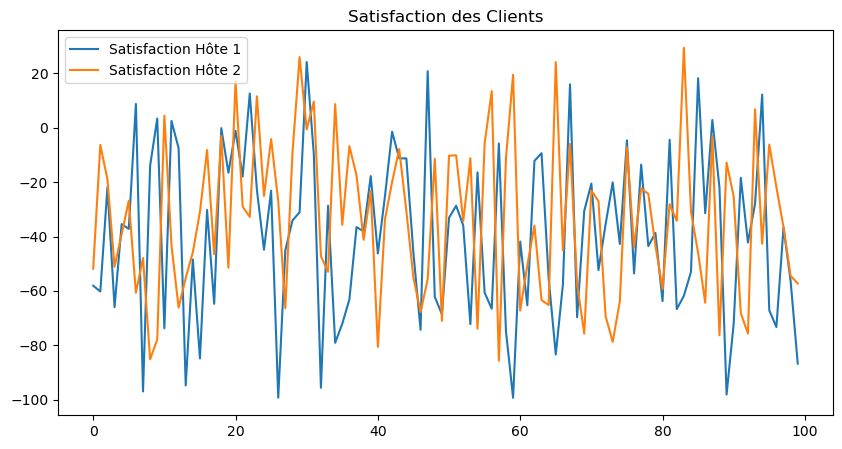

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Fonction de demande des clients (basée sur le prix et la qualité)
def demande(prix, qualite):
    # La demande diminue avec l'augmentation du prix
    demande_base = 100  # Demande de base si le prix est optimal
    if qualite == 'haute':
        demande_base += 20  # Demande augmente avec une meilleure qualité
    return max(0, demande_base - 0.5 * prix)

# Fonction de satisfaction des clients
def satisfaction(qualite, prix):
    satisfaction_base = 50
    if qualite == 'haute':
        satisfaction_base += 30  # Satisfaction plus élevée avec qualité haute
    satisfaction_base -= prix  # Réduction de la satisfaction en fonction du prix
    return satisfaction_base

# Coût du service (dépend de la qualité)
def cout_service(qualite):
    return 20 if qualite == 'faible' else 40

# Simulation de plusieurs jeux avec différents prix et qualités
def simulate_game():
    # Choix de stratégie des hôtes
    prix_hote_1 = np.random.uniform(50, 150)
    prix_hote_2 = np.random.uniform(50, 150)
    
    qualite_hote_1 = 'haute' if np.random.rand() > 0.5 else 'faible'
    qualite_hote_2 = 'haute' if np.random.rand() > 0.5 else 'faible'
    
    # Demande des clients pour chaque hôte
    demande_hote_1 = demande(prix_hote_1, qualite_hote_1)
    demande_hote_2 = demande(prix_hote_2, qualite_hote_2)
    
    # Paiement des hôtes
    revenu_hote_1 = prix_hote_1 * demande_hote_1 - cout_service(qualite_hote_1)
    revenu_hote_2 = prix_hote_2 * demande_hote_2 - cout_service(qualite_hote_2)
    
    # Satisfaction des clients
    satisfaction_hote_1 = satisfaction(qualite_hote_1, prix_hote_1)
    satisfaction_hote_2 = satisfaction(qualite_hote_2, prix_hote_2)
    
    return revenu_hote_1, revenu_hote_2, satisfaction_hote_1, satisfaction_hote_2

# Simulation de plusieurs jeux pour observer l'évolution des stratégies
def run_simulation(num_games=100):
    revenus_hote_1 = []
    revenus_hote_2 = []
    satisfactions_hote_1 = []
    satisfactions_hote_2 = []
    
    for _ in range(num_games):
        r1, r2, s1, s2 = simulate_game()
        revenus_hote_1.append(r1)
        revenus_hote_2.append(r2)
        satisfactions_hote_1.append(s1)
        satisfactions_hote_2.append(s2)
    
    # Affichage des résultats
    plt.figure(figsize=(10, 5))
    plt.plot(revenus_hote_1, label='Revenu Hôte 1')
    plt.plot(revenus_hote_2, label='Revenu Hôte 2')
    plt.title('Revenus des Hôtes')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.plot(satisfactions_hote_1, label='Satisfaction Hôte 1')
    plt.plot(satisfactions_hote_2, label='Satisfaction Hôte 2')
    plt.title('Satisfaction des Clients')
    plt.legend()
    plt.show()

# Exécution de la simulation pour 100 jeux
run_simulation(100)


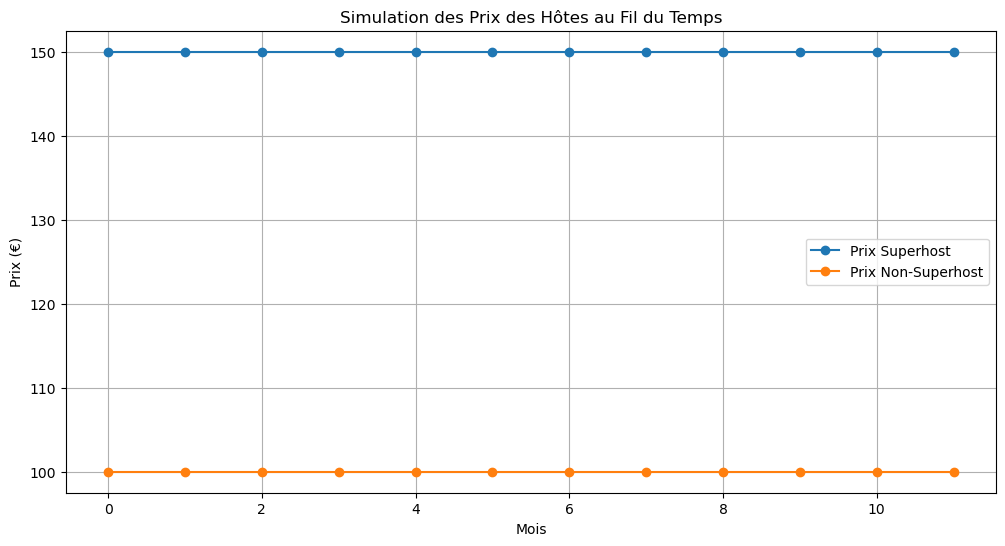

    Superhost Price  Non-Superhost Price
0             150.0                100.0
1             150.0                100.0
2             150.0                100.0
3             150.0                100.0
4             150.0                100.0
5             150.0                100.0
6             150.0                100.0
7             150.0                100.0
8             150.0                100.0
9             150.0                100.0
10            150.0                100.0
11            150.0                100.0


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Paramètres
num_months = 12  # Nombre de mois pour la simulation
num_hosts = 2     # Nombre d'hôtes (1 superhost, 1 non-superhost)
superhost_reputation = 1.2  # Facteur de réputation pour le superhost
initial_price_superhost = 150  # Prix initial du superhost
initial_price_non_superhost = 100  # Prix initial du non-superhost
sensitivity_to_price = 0.05  # Sensibilité à la variation des prix
client_demand = 100  # Demande initiale de clients
base_satisfaction = 80  # Satisfaction de base

# Initialisation des prix
prices = np.zeros((num_months, num_hosts))
prices[0] = [initial_price_superhost, initial_price_non_superhost]

# Simulation du jeu sur plusieurs mois
for month in range(1, num_months):
    # Récupération des prix du mois précédent
    price_superhost = prices[month - 1, 0]
    price_non_superhost = prices[month - 1, 1]
    
    # Calcul de la demande en fonction des prix
    demand_superhost = client_demand * (1 - sensitivity_to_price * (price_superhost - price_non_superhost))
    demand_non_superhost = client_demand * (1 - sensitivity_to_price * (price_non_superhost - price_superhost))
    
    # Calcul de la satisfaction pour chaque hôte
    satisfaction_superhost = base_satisfaction * superhost_reputation - price_superhost
    satisfaction_non_superhost = base_satisfaction - price_non_superhost
    
    # Mise à jour des prix en fonction de la demande et de la satisfaction
    # Ici, les hôtes ajustent leurs prix pour maximiser leur revenu
    new_price_superhost = price_superhost + 5 * (demand_superhost > 0)  # Augmente le prix si demande
    new_price_non_superhost = price_non_superhost - 5 * (demand_non_superhost < 0)  # Diminue le prix si faible demande
    
    prices[month] = [new_price_superhost, new_price_non_superhost]

# Création d'un DataFrame pour les résultats
results = pd.DataFrame(prices, columns=['Superhost Price', 'Non-Superhost Price'])

# Affichage des résultats
plt.figure(figsize=(12, 6))
plt.plot(results['Superhost Price'], label='Prix Superhost', marker='o')
plt.plot(results['Non-Superhost Price'], label='Prix Non-Superhost', marker='o')
plt.title('Simulation des Prix des Hôtes au Fil du Temps')
plt.xlabel('Mois')
plt.ylabel('Prix (€)')
plt.legend()
plt.grid()
plt.show()

# Affichage des prix
print(results)


Meilleur prix pour Superhost (A) : 200.0 €
Meilleur prix pour Non-superhost (B) : 100.0 €
Gain pour Superhost (A) : 950.0 €
Gain pour Non-superhost (B) : 970.0 €


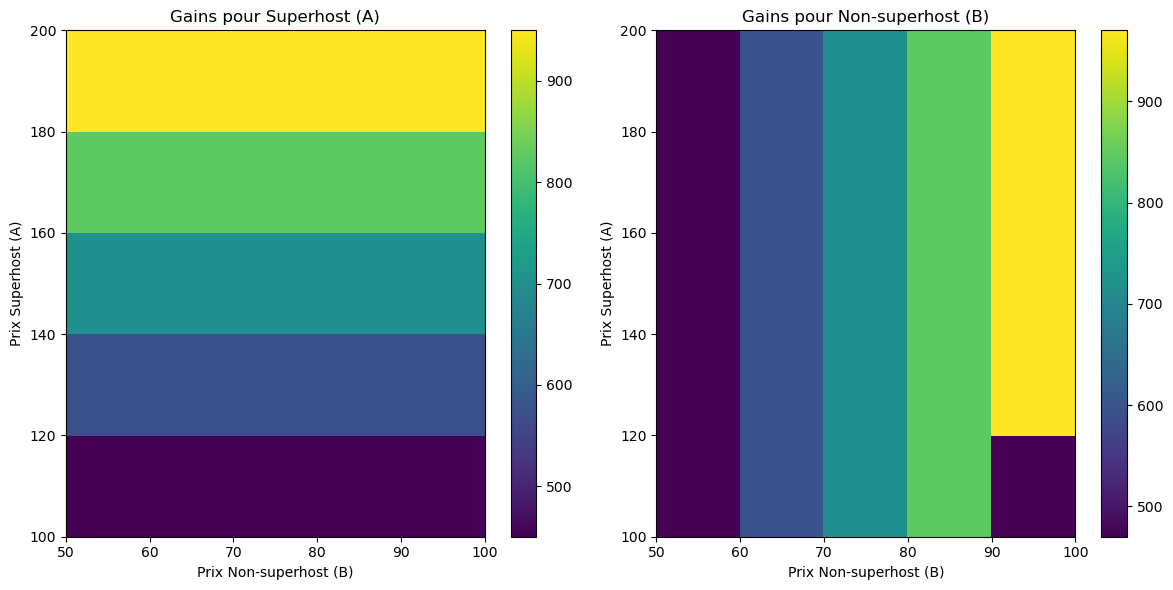

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres du jeu
# Hôtes (superhost, non-superhost) et clients
num_hotes = 2  # Superhost (A) et Non-superhost (B)
num_clients = 10  # Nombre de clients potentiels

# Stratégies des hôtes : prix possibles (dans un intervalle donné)
prix_superhost = np.linspace(100, 200, 5)  # Prix possibles pour Superhost (A)
prix_non_superhost = np.linspace(50, 100, 5)  # Prix possibles pour Non-superhost (B)

# Satisfaction des clients en fonction du prix
def satisfaction(prix, reputation):
    """
    Fonction de satisfaction en fonction du prix et de la réputation.
    Plus le prix est bas et la réputation est bonne, plus la satisfaction est élevée.
    """
    base_satisfaction = 100 - prix  # Satisfaction de base décroît avec le prix
    if reputation == 'superhost':
        base_satisfaction += 10  # Bonus pour la bonne réputation
    return base_satisfaction

# Demande des clients en fonction des prix
def demande(prix_A, prix_B):
    """
    Fonction de demande en fonction des prix des hôtes A et B.
    La demande est influencée par la concurrence entre les deux hôtes.
    """
    if prix_A < prix_B:
        return num_clients  # Plus de clients pour A si son prix est plus bas
    elif prix_A > prix_B:
        return num_clients // 2  # Moins de clients pour A si son prix est plus élevé
    else:
        return num_clients // 2  # Si les prix sont égaux, la demande est partagée

# Gains des hôtes
def gain_hote(prix, demande, cout_service):
    """
    Fonction de gain d'un hôte.
    Le gain dépend du prix fixé, de la demande et du coût du service.
    """
    return prix * demande - cout_service

# Simulation du jeu
def simulation():
    """
    Simulation d'un jeu entre un Superhost (A) et un Non-superhost (B).
    Chaque hôte fixe son prix pour maximiser son gain en fonction de la demande des clients.
    """
    # Coûts des services des hôtes
    cout_superhost = 50
    cout_non_superhost = 30

    # Simulation des choix de prix (stratégies) pour les deux hôtes
    best_gain_A = -np.inf
    best_gain_B = -np.inf
    best_prix_A = None
    best_prix_B = None

    for prix_A in prix_superhost:
        for prix_B in prix_non_superhost:
            # Demande de clients
            demande_A = demande(prix_A, prix_B)
            demande_B = demande(prix_B, prix_A)
            
            # Satisfaction des clients
            satisfaction_A = satisfaction(prix_A, 'superhost')
            satisfaction_B = satisfaction(prix_B, 'non-superhost')
            
            # Gains des hôtes
            gain_A = gain_hote(prix_A, demande_A, cout_superhost)
            gain_B = gain_hote(prix_B, demande_B, cout_non_superhost)

            # Mise à jour des meilleures stratégies (équilibre de Nash)
            if gain_A > best_gain_A:
                best_gain_A = gain_A
                best_prix_A = prix_A
            if gain_B > best_gain_B:
                best_gain_B = gain_B
                best_prix_B = prix_B

    return best_prix_A, best_prix_B, best_gain_A, best_gain_B

# Exécution de la simulation
best_prix_A, best_prix_B, best_gain_A, best_gain_B = simulation()

print(f"Meilleur prix pour Superhost (A) : {best_prix_A} €")
print(f"Meilleur prix pour Non-superhost (B) : {best_prix_B} €")
print(f"Gain pour Superhost (A) : {best_gain_A} €")
print(f"Gain pour Non-superhost (B) : {best_gain_B} €")

# Visualisation des stratégies de prix
prix_A_values = np.linspace(100, 200, 5)
prix_B_values = np.linspace(50, 100, 5)

gains_A = []
gains_B = []

for prix_A in prix_A_values:
    for prix_B in prix_B_values:
        demande_A = demande(prix_A, prix_B)
        demande_B = demande(prix_B, prix_A)
        gain_A = gain_hote(prix_A, demande_A, 50)
        gain_B = gain_hote(prix_B, demande_B, 30)
        gains_A.append(gain_A)
        gains_B.append(gain_B)

gains_A = np.array(gains_A).reshape(len(prix_A_values), len(prix_B_values))
gains_B = np.array(gains_B).reshape(len(prix_A_values), len(prix_B_values))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(gains_A, extent=[50, 100, 100, 200], origin='lower', aspect='auto')
plt.colorbar()
plt.title('Gains pour Superhost (A)')
plt.xlabel('Prix Non-superhost (B)')
plt.ylabel('Prix Superhost (A)')

plt.subplot(1, 2, 2)
plt.imshow(gains_B, extent=[50, 100, 100, 200], origin='lower', aspect='auto')
plt.colorbar()
plt.title('Gains pour Non-superhost (B)')
plt.xlabel('Prix Non-superhost (B)')
plt.ylabel('Prix Superhost (A)')

plt.tight_layout()
plt.show()


##### Les graphiques montrent les gains pour deux types d'hôtes, Superhost (A) et Non-superhost (B), en fonction des prix fixés pour les hôtes non-superhost (axe des abscisses). Ces graphes peuvent suggérer que le prix pour l'hôte Superhost est relativement élevé et généré par une combinaison de catégories (représentées par les différentes couleurs) qui augmentent à mesure que le prix de l'hôte non-superhost (axe des x) augmente.

### Interprétation principale :

#### Pour l'hôte Superhost (A) :
 Lorsque le prix pour l'hôte non-superhost est bas (près de 50), les gains sont très faibles, mais ils augmentent considérablement à mesure que le prix pour l'hôte non-superhost augmente, atteignant un maximum autour de 100.
### Pour l'hôte Non-superhost (B) : 
Il semble y avoir une plus grande stabilité, avec moins de variations visibles dans les gains, malgré l'augmentation progressive des prix. Les gains augmentent, mais de manière plus régulière.

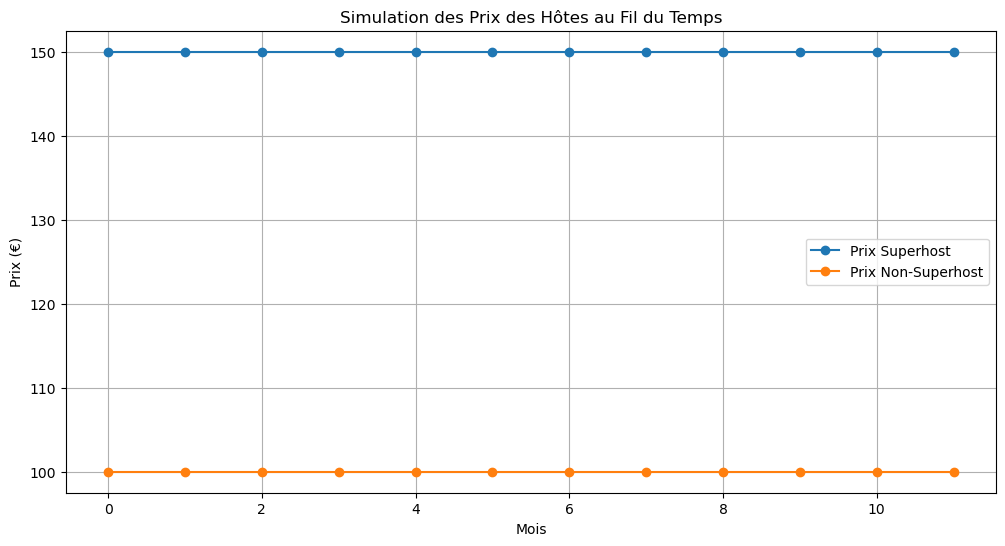

    Superhost Price  Non-Superhost Price
0             150.0                100.0
1             150.0                100.0
2             150.0                100.0
3             150.0                100.0
4             150.0                100.0
5             150.0                100.0
6             150.0                100.0
7             150.0                100.0
8             150.0                100.0
9             150.0                100.0
10            150.0                100.0
11            150.0                100.0


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Paramètres
num_months = 12  # Nombre de mois pour la simulation
num_hosts = 2     # Nombre d'hôtes (1 superhost, 1 non-superhost)
superhost_reputation = 1.2  # Facteur de réputation pour le superhost
initial_price_superhost = 150  # Prix initial du superhost
initial_price_non_superhost = 100  # Prix initial du non-superhost
sensitivity_to_price = 0.05  # Sensibilité à la variation des prix
client_demand = 100  # Demande initiale de clients
base_satisfaction = 80  # Satisfaction de base

# Initialisation des prix
prices = np.zeros((num_months, num_hosts))
prices[0] = [initial_price_superhost, initial_price_non_superhost]

# Simulation du jeu sur plusieurs mois
for month in range(1, num_months):
    # Récupération des prix du mois précédent
    price_superhost = prices[month - 1, 0]
    price_non_superhost = prices[month - 1, 1]
    
    # Calcul de la demande en fonction des prix
    demand_superhost = client_demand * (1 - sensitivity_to_price * (price_superhost - price_non_superhost))
    demand_non_superhost = client_demand * (1 - sensitivity_to_price * (price_non_superhost - price_superhost))
    
    # Calcul de la satisfaction pour chaque hôte
    satisfaction_superhost = base_satisfaction * superhost_reputation - price_superhost
    satisfaction_non_superhost = base_satisfaction - price_non_superhost
    
    # Mise à jour des prix en fonction de la demande et de la satisfaction
    # Ici, les hôtes ajustent leurs prix pour maximiser leur revenu
    new_price_superhost = price_superhost + 5 * (demand_superhost > 0)  # Augmente le prix si demande
    new_price_non_superhost = price_non_superhost - 5 * (demand_non_superhost < 0)  # Diminue le prix si faible demande
    
    prices[month] = [new_price_superhost, new_price_non_superhost]

# Création d'un DataFrame pour les résultats
results = pd.DataFrame(prices, columns=['Superhost Price', 'Non-Superhost Price'])

# Affichage des résultats
plt.figure(figsize=(12, 6))
plt.plot(results['Superhost Price'], label='Prix Superhost', marker='o')
plt.plot(results['Non-Superhost Price'], label='Prix Non-Superhost', marker='o')
plt.title('Simulation des Prix des Hôtes au Fil du Temps')
plt.xlabel('Mois')
plt.ylabel('Prix (€)')
plt.legend()
plt.grid()
plt.show()

# Affichage des prix
print(results)


Hôte 1: Prix d'équilibre = 150.00, Qualité = superhost
Hôte 2: Prix d'équilibre = 150.00, Qualité = superhost
Hôte 3: Prix d'équilibre = 137.89, Qualité = standard
Hôte 4: Prix d'équilibre = 138.30, Qualité = superhost
Hôte 5: Prix d'équilibre = 140.55, Qualité = standard
Hôte 6: Prix d'équilibre = 141.41, Qualité = standard
Hôte 7: Prix d'équilibre = 138.07, Qualité = standard
Hôte 8: Prix d'équilibre = 143.69, Qualité = superhost
Hôte 9: Prix d'équilibre = 150.00, Qualité = standard
Hôte 10: Prix d'équilibre = 150.00, Qualité = standard


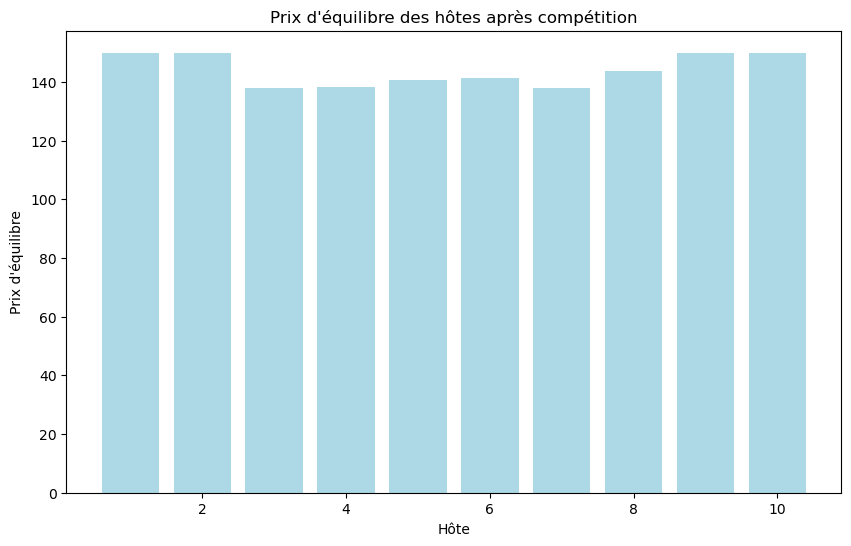

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Fonction de demande des clients en fonction des prix
def demande(hote_prix, autres_prix, qualite, num_clients=100):
    """
    Fonction qui retourne la demande pour un hôte en fonction de son prix et de celui des autres hôtes.
    Arguments :
    - hote_prix : prix de l'hôte considéré
    - autres_prix : liste des prix des autres hôtes
    - qualite : qualité du service (superhost ou non, etc.)
    - num_clients : nombre total de clients potentiels
    """
    prix_moyen_autres = np.mean(autres_prix)
    
    # Si l'hôte est un superhost, il attire plus de clients malgré un prix plus élevé
    bonus_qualite = 1.2 if qualite == 'superhost' else 1.0
    
    # La demande diminue si le prix est plus élevé que la moyenne des autres hôtes
    if hote_prix < prix_moyen_autres:
        demande_relative = num_clients * 0.6 * bonus_qualite
    elif hote_prix > prix_moyen_autres:
        demande_relative = num_clients * 0.4 * bonus_qualite
    else:
        demande_relative = num_clients * 0.5 * bonus_qualite
    
    return demande_relative

# Fonction de revenu de l'hôte
def revenu(hote_prix, autres_prix, qualite, num_clients=100):
    """
    Fonction qui calcule le revenu d'un hôte en fonction de son prix et de la demande.
    Arguments :
    - hote_prix : prix de l'hôte
    - autres_prix : liste des prix des autres hôtes
    - qualite : qualité du service
    - num_clients : nombre total de clients potentiels
    """
    demande_hote = demande(hote_prix, autres_prix, qualite, num_clients)
    cout_service = 50  # Coût fixe pour le service de l'hôte
    return demande_hote * hote_prix - cout_service

# Simulation de l'ajustement des prix jusqu'à un équilibre
def simuler_concurrence(nb_hotes, iterations=100):
    """
    Simule la concurrence par les prix entre plusieurs hôtes et cherche un équilibre.
    Arguments :
    - nb_hotes : nombre total d'hôtes
    - iterations : nombre d'itérations pour ajuster les prix
    """
    prix_initials = np.random.uniform(50, 150, size=nb_hotes)
    qualites = np.random.choice(['superhost', 'standard'], size=nb_hotes)
    
    prix_actuels = prix_initials.copy()
    
    for it in range(iterations):
        for i in range(nb_hotes):
            autres_prix = np.delete(prix_actuels, i)  # Exclure le prix de l'hôte i
            
            # Calculer le revenu pour un prix légèrement ajusté
            prix_bas = max(50, prix_actuels[i] - 5)  # Limite inférieure du prix
            prix_haut = min(150, prix_actuels[i] + 5)  # Limite supérieure du prix
            
            revenu_bas = revenu(prix_bas, autres_prix, qualites[i])
            revenu_haut = revenu(prix_haut, autres_prix, qualites[i])
            
            # Ajuster le prix vers la direction qui maximise le revenu
            if revenu_haut > revenu_bas:
                prix_actuels[i] = prix_haut
            else:
                prix_actuels[i] = prix_bas
    
    return prix_actuels, qualites

# Simulation avec 10 hôtes
nb_hotes = 10
iterations = 100
prix_equilibres, qualites = simuler_concurrence(nb_hotes, iterations)

# Affichage des résultats
for i in range(nb_hotes):
    print(f"Hôte {i+1}: Prix d'équilibre = {prix_equilibres[i]:.2f}, Qualité = {qualites[i]}")

# Visualisation
plt.figure(figsize=(10, 6))
plt.bar(range(1, nb_hotes+1), prix_equilibres, color='lightblue')
plt.xlabel('Hôte')
plt.ylabel('Prix d\'équilibre')
plt.title('Prix d\'équilibre des hôtes après compétition')
plt.show()


### 1. Différences de prix d'équilibre :
Les hôtes 1, 2, 9, et 10 affichent un prix d'équilibre à 150. Ces hôtes ont tous soit le statut de superhost (pour les hôtes 1 et 2) ou une grande compétitivité, ce qui signifie que ces hôtes ont pu maintenir des prix élevés tout en conservant une forte demande.
Les autres hôtes (3 à 8) ont des prix d'équilibre légèrement plus bas, variant entre 137.89 et 143.69. Cela pourrait être dû à une plus forte concurrence ou à une qualité perçue inférieure.
### 2. Impact de la qualité (Superhost) :
Les hôtes 1, 2, 4, et 8 sont des superhosts, ce qui leur donne un certain avantage compétitif, comme le montre la répartition de leurs prix. Les superhosts peuvent se permettre de fixer des prix plus élevés en raison de leur bonne réputation, ce qui attire plus de clients, même à un prix plus élevé.
En revanche, les hôtes sans ce statut (qualité standard) tendent à avoir des prix légèrement plus bas, comme on le voit avec l'hôte 3, par exemple.
### 3. Concurrence et ajustement des prix :
Le fait que les prix des hôtes convergent vers des valeurs proches les uns des autres montre un équilibre concurrentiel où les hôtes ont ajusté leurs prix pour maximiser leurs revenus tout en restant compétitifs. Le processus d'ajustement montre que chaque hôte a trouvé un prix où il n'a plus intérêt à le modifier, conduisant à un équilibre de Nash.
### 4. Distribution des prix :
La majorité des prix se situent entre 137.89 et 150, avec très peu de dispersion. Cela suggère que, dans cette simulation, les hôtes ne se différencient pas fortement sur les prix, sauf pour quelques variations en fonction de la qualité du service (superhost ou non).